В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

In [20]:
!pip install torch_geometric --quiet
!pip install nni --quiet

Импортируем необходимые библиотеки

In [21]:
import os
import json
import re
import io

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from graphviz import Digraph
from IPython.display import display, clear_output
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, random_split, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GraphNorm
from torch_geometric.utils import dense_to_sparse

import nni
from nni.nas.evaluator.pytorch import DataLoader, Classification
from nni.nas.hub.pytorch import DARTS as DartsSpace
from nni.nas.space import model_context
from itertools import combinations

from joblib import Parallel, delayed
from multiprocessing import Pool, cpu_count
import itertools

Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [22]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [23]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [24]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [31]:
models_dict = load_json_from_directory('/kaggle/input/second-dataset/third_dataset/')

Посмотрю как распределена точность моделей

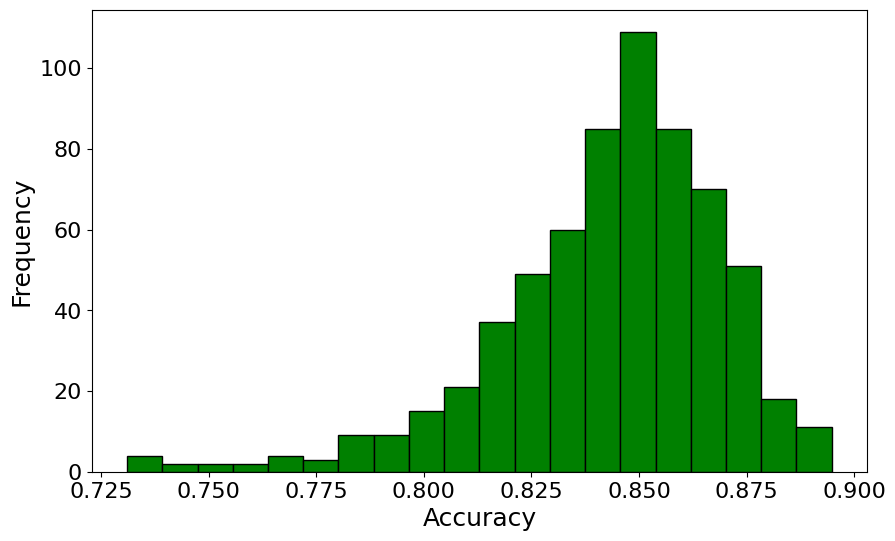

In [32]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black', color="green")
# plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [33]:
def extract_cells(arch_dict):
    normal_cell, reduction_cell = [], []
    tmp_list = []

    for key, value in arch_dict["architecture"].items():
        if key.startswith("normal/") or key.startswith("reduce/"):
            tmp_list.extend([key, value])

        if len(tmp_list) == 4:
            tmp_list.pop(2)
            if key.startswith("normal/"):
                normal_cell.append(tmp_list)
            else:
                reduction_cell.append(tmp_list)
            tmp_list = []

    return normal_cell, reduction_cell

Создадам базовый класс узла графа

In [34]:
class Vertex:
    def __init__(self, op, in_channel, out_channel):
        self.op = op
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.op_one_hot = DARTS_OPS_ONE_HOT[DARTS_OPS.index(op)]

    def __str__(self):
        return f"Op: {self.op} | In: {self.in_channel} | Out: {self.out_channel}"
    def __repr__(self):
        return self.__str__()

Напишу сам класс графа. 

Замечу, что в классе будет хранится индекс соответствующий положению архитектуры в массиве словарей импортированном раннее.

In [35]:
class Graph(torch.utils.data.Dataset):
    def __init__(self, model_dict, index=0):
        self.model_dict = model_dict
        self.normal_cell, self.reduction_cell = extract_cells(model_dict)

        self._normal_graph = self.make_graph(self.normal_cell)
        self._reduction_graph = self.make_graph(self.reduction_cell)

        self.normal_num_vertices, self.reduction_num_vertices = self.__len__()

        self.graph = self.make_full_graph()
        self.index = index

    def __len__(self):
        max_normal_out = max(vertex.out_channel for vertex in self._normal_graph)
        max_reduction_out = max(vertex.out_channel for vertex in self._reduction_graph)
        return max_normal_out, max_reduction_out

    def graph_size(self, graph):
        return max((vertex.out_channel for vertex in graph), default=0)

    def make_full_graph(self):
        graph = [vertex for vertex in self._normal_graph]
        graph = self._unite_graphs(graph, self._reduction_graph)

        max_channel_diff, _ = self.__len__()
        graph.append(Vertex("none", max_channel_diff * 2 + 1, max_channel_diff * 2 + 1))

        return graph

    def _unite_graphs(self, graph1, graph2):
        graph1_size = self.graph_size(graph1)
        new_graph = [vertex for vertex in graph1]
        for vertex in graph2:
            new_vertex = Vertex(
                vertex.op,
                vertex.in_channel + graph1_size,
                vertex.out_channel + graph1_size,
            )
            new_graph.append(new_vertex)

        new_graph.sort(key=lambda vertex: (vertex.in_channel, vertex.out_channel))

        return new_graph

    def make_graph(self, cell):
        graph = []
        for value in cell:
            in_channel = int(value[2][0])
            out_channel = int(re.search(r"op_(\d+)_", value[0]).group(1))
            op = value[1]
            graph.append(Vertex(op, in_channel, out_channel))
        graph.append(Vertex("none", 0, 0))
        graph.append(Vertex("none", 1, 1))

        graph.sort(key=lambda vertex: (vertex.in_channel, vertex.out_channel))

        return graph

    def show_graph(self):
        adj_matrix, operations, _ = self.get_adjacency_matrix()
        graph_name = "Graph"

        dot = Digraph(comment=graph_name, format="png")
        dot.attr(rankdir="TB")

        num_nodes = len(self.graph)

        # Добавляем узлы с оригинальными метками
        for idx, vertex in enumerate(self.graph):
            label = (
                f"{{Op: {vertex.op} | "
                f"In: {vertex.in_channel} | "
                f"Out: {vertex.out_channel}}}"
            )
            dot.node(str(idx), label=label, shape="record")

        # Добавляем связи на основе матрицы смежности
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i, j] == 1:
                    dot.edge(str(i), str(j))

        display(dot)

    def get_normal_graph(self):
        return self._normal_graph

    def get_reduction_graph(self):
        return self._reduction_graph

    def get_adjacency_matrix(self):
        adj_matrix_size = len(self.graph)
        max_channel_diff, _ = self.__len__()
        adj_matrix = np.zeros(shape=(adj_matrix_size, adj_matrix_size))

        operations = [vertex.op for vertex in self.graph]
        operations_one_hot = [vertex.op_one_hot for vertex in self.graph]
        for i in range(adj_matrix_size):
            for j in range(adj_matrix_size):
                if j == i:
                    continue
                vertex_1 = self.graph[i]
                vertex_2 = self.graph[j]

                if (vertex_1.out_channel == vertex_2.in_channel) and (
                    (
                        vertex_1.in_channel <= max_channel_diff
                        and vertex_2.out_channel <= max_channel_diff
                    )
                    or (
                        vertex_1.in_channel >= max_channel_diff
                        and vertex_2.out_channel >= max_channel_diff
                    )
                ):

                    adj_matrix[i, j] = 1

                if (  # Добавляем ребро из c_k на вход следующей клетке
                    (vertex_1.op == "none")
                    and (vertex_2.op == "none")
                    and (vertex_1.out_channel == 1)
                    and (vertex_2.in_channel == 6)
                ):
                    adj_matrix[i, j] = 1

        # Соединим оставшиеся узлы с выходом.

        for i in range(adj_matrix_size):
            for j in range(adj_matrix_size):
                if j == i:
                    continue
                vertex_1 = self.graph[i]
                vertex_2 = self.graph[j]

                if (np.all(adj_matrix[i, :] == 0)) and (
                    (
                        (vertex_2.op == "none")
                        and (vertex_2.in_channel == max_channel_diff)
                        and (vertex_1.in_channel < max_channel_diff)
                    )
                    or (
                        (vertex_2.out_channel == 2 * max_channel_diff + 1)
                        and (vertex_1.out_channel > max_channel_diff)
                    )
                ):
                    adj_matrix[i, j] = 1

        adj_matrix = np.array(adj_matrix)
        operations_one_hot = np.array(operations_one_hot)
        return adj_matrix, operations, operations_one_hot

In [36]:
graph = Graph(models_dict[0])

Посмотрю как выглядит граф.

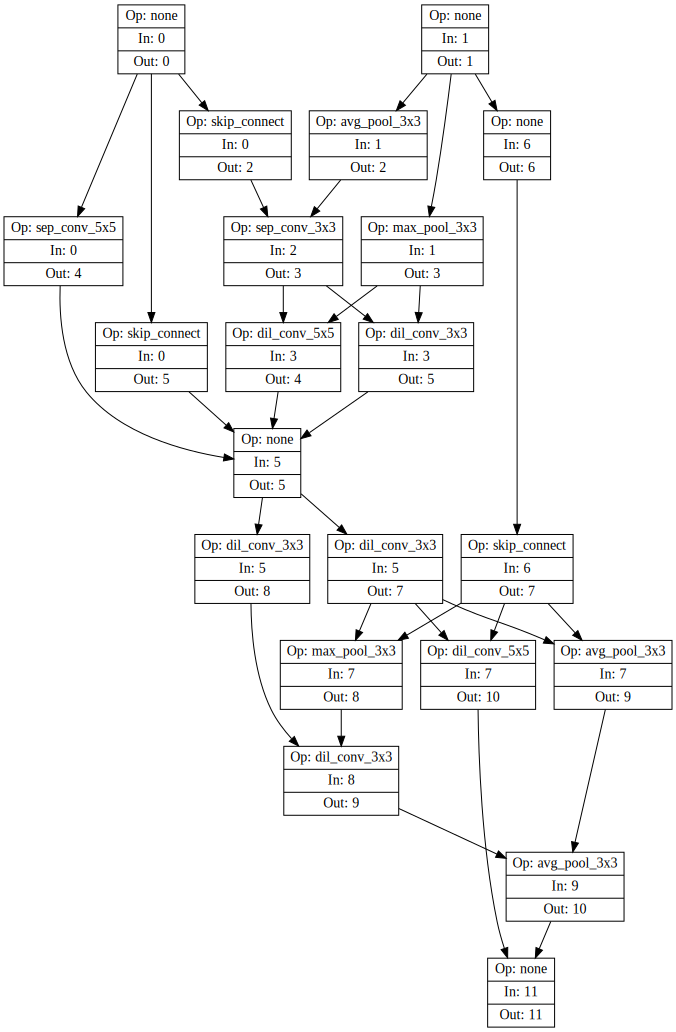

In [37]:
graph.show_graph()

In [38]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


In [39]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: skip_connect | In: 0 | Out: 2,
 Op: sep_conv_5x5 | In: 0 | Out: 4,
 Op: skip_connect | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: avg_pool_3x3 | In: 1 | Out: 2,
 Op: max_pool_3x3 | In: 1 | Out: 3,
 Op: sep_conv_3x3 | In: 2 | Out: 3,
 Op: dil_conv_5x5 | In: 3 | Out: 4,
 Op: dil_conv_3x3 | In: 3 | Out: 5]

In [40]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: dil_conv_3x3 | In: 0 | Out: 2,
 Op: dil_conv_3x3 | In: 0 | Out: 3,
 Op: none | In: 1 | Out: 1,
 Op: skip_connect | In: 1 | Out: 2,
 Op: max_pool_3x3 | In: 2 | Out: 3,
 Op: avg_pool_3x3 | In: 2 | Out: 4,
 Op: dil_conv_5x5 | In: 2 | Out: 5,
 Op: dil_conv_3x3 | In: 3 | Out: 4,
 Op: avg_pool_3x3 | In: 4 | Out: 5]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [41]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [42]:
def get_diversity(args):
    i, j, model_i, model_j, num_samples = args
    indices = np.random.choice(len(model_i["test_predictions"]), num_samples, replace=False)
    preds_i = np.array(model_i["test_predictions"])[indices]
    preds_j = np.array(model_j["test_predictions"])[indices]
    distance = np.mean(preds_i == preds_j)
    return (i, j, distance)

def get_diversity_using_jensen_shannon(args):
    i, j, model_i, model_j, num_samples = args
    indices = np.random.choice(len(model_i["test_predictions"]), num_samples, replace=False)
    preds_i = np.array(model_i["test_predictions"])[indices]
    preds_j = np.array(model_j["test_predictions"])[indices]
    distance = np.mean([jensenshannon(p1, p2) for p1, p2 in zip(preds_i, preds_j)])
    return (i, j, distance)

Построю матрицу разнообразия

In [43]:
def get_diversity_matrix_naive(models_dict, num_samples=1000):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            diversity_matrix[i, j] = get_diversity((i, j, models_dict[i], models_dict[j], num_samples))[-1]
            diversity_matrix[j, i] = diversity_matrix[i, j]

    return diversity_matrix

def get_diversity_matrix(models_dict, num_samples=2000):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    pairs = [
        (i, j, models_dict[i], models_dict[j], num_samples)  # i, j, model_i, model_j, num_samples
        for i, j in itertools.combinations(range(n_models), 2)
    ]

    with Pool(processes=cpu_count()) as pool:
        results = list(
            tqdm(
                pool.imap_unordered(get_diversity_using_jensen_shannon, pairs),
                total=len(pairs),
                desc="Расчет матрицы разнообразия",
            )
        )

    for i, j, dist in results:
        diversity_matrix[i, j] = dist
        diversity_matrix[j, i] = dist

    return diversity_matrix

In [44]:
diversity_matrix = get_diversity_matrix_naive(models_dict, num_samples=10000)

Computing diversity matrix: 100%|██████████| 646/646 [04:37<00:00,  2.33it/s]


100%|██████████| 646/646 [00:00<00:00, 11711.63it/s]


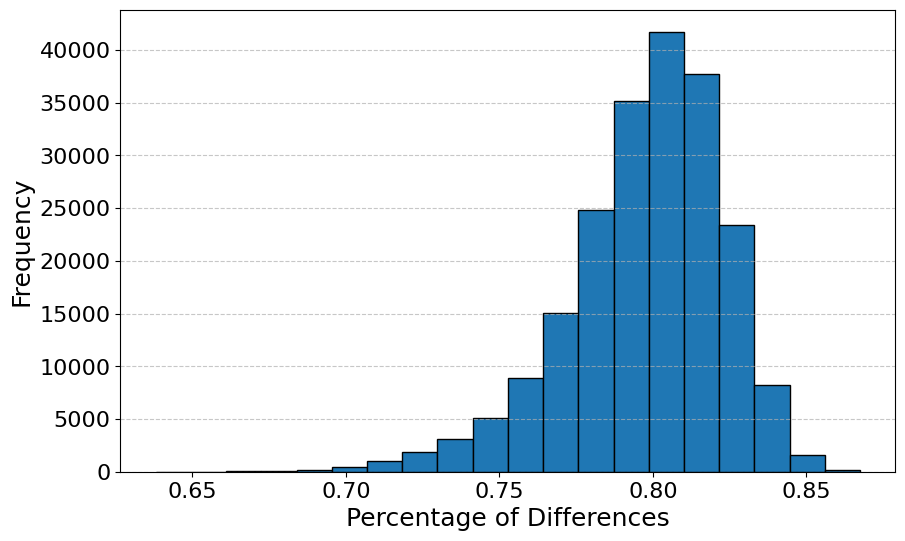

In [45]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=20, edgecolor="black")
# plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

В ней 1 -- positive, -1 -- negative, 0 в ином случае.

In [46]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    upper_margins = np.quantile(diversity_matrix, 0.90, axis=1)
    lower_margins = np.quantile(diversity_matrix, 0.1, axis=1)

    discrete_diversity_matrix[diversity_matrix > upper_margins[:, None]] = 1
    discrete_diversity_matrix[diversity_matrix < lower_margins[:, None]] = -1

    return discrete_diversity_matrix

In [47]:
def get_positive_and_negative(diversity_matrix, index, dataset=None):
    positive = np.where((diversity_matrix[index, :] == 1) & (np.arange(len(diversity_matrix)) != index))[0].tolist()
    negative = np.where(diversity_matrix[index, :] == -1)[0].tolist()

    if dataset is not None:
        appropriate_indexes = [dataset[i][2] for i in range(len(dataset))]

        positive = [appropriate_indexes.index(idx) for idx in positive if idx in appropriate_indexes]
        negative = [appropriate_indexes.index(idx) for idx in negative if idx in appropriate_indexes]

    if not positive or not negative:
        print("Both positive and negative samples are empty!")
        return None, None

    return np.random.choice(positive), np.random.choice(negative)


In [48]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Код GCN

In [49]:
class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, dropout=0.5, pooling="max"):
        """
        input_dim: размер входных признаков узлов
        hidden_dim: размер скрытого пространства в графовых свёрточных слоях
        embedding_dim: размер итогового графового эмбеддинга
        dropout: вероятность исключения узлов для регуляризации
        pooling: тип агрегации ('max', 'mean' или 'sum')
        """
        super(SimpleGCN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.gc1 = GCNConv(input_dim, hidden_dim)
        self.gc2 = GCNConv(hidden_dim, hidden_dim)
        self.graph_norm = GraphNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))
        x = self.graph_norm(x)
        x = self.dropout(x)
        
        x = F.relu(self.gc2(x, edge_index))
        x = self.graph_norm(x)
        x = self.dropout(x)
        
        # Глобальное агрегирование узловых признаков для получения представления всего графа
        if self.pooling == "max":
            pooled = torch.max(x, dim=0).values 
        elif self.pooling == "mean":
            pooled = torch.mean(x, dim=0)
        elif self.pooling == "sum":
            pooled = torch.sum(x, dim=0)
        else:
            raise ValueError("Unsupported pooling method. Use 'max', 'mean' или 'sum'.")
        
        # Преобразование агрегированного представления в эмбеддинг графа
        embedding = self.fc(pooled)

        if self.embedding_dim == 1:
            embedding = nn.Sigmoid()(embedding)
        return embedding
    
class GCN(nn.Module):
    def __init__(self, input_dim, output_dim=16, dropout=0.5, pooling="max"):
        super(GCN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.gc1 = GCNConv(input_dim, 64)
        self.gc2 = GCNConv(64, 128)
        self.gc3 = GCNConv(128, 64)
        self.layer_norm = nn.LayerNorm(64)  
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.pooling = pooling

        self.key = nn.Linear(128, 128)
        self.query = nn.Linear(128, 128)

        self.residual_proj = nn.Linear(input_dim, 64) if input_dim != 64 else nn.Identity()

    def forward(self, x, edge_index):
        residual = self.residual_proj(x)

        x = F.leaky_relu(self.gc1(x, edge_index))
        x = self.dropout(x)

        x = F.leaky_relu(self.gc2(x, edge_index))
        x = self.dropout(x)

        keys = self.key(x)  # [N, 128]
        queries = self.query(x)  # [N, 128]
        attn_scores = torch.mm(queries, keys.T)  # [N, N]

        row, col = edge_index
        mask = torch.zeros_like(attn_scores)
        mask[row, col] = 1  
        attn_scores = attn_scores * mask  
        attn_scores = F.softmax(attn_scores, dim=-1)

        x = torch.mm(attn_scores, x)  # [N, N] * [N, 128] → [N, 128]

        x = F.leaky_relu(self.gc3(x, edge_index))
        x = self.dropout(x)

        x = self.layer_norm(x + residual)  # LayerNorm
       
        if self.pooling == "max":
            x = torch.max(x, dim=0).values
        elif self.pooling == "mean":
            x = torch.mean(x, dim=0)
        elif self.pooling == "sum":
            x = torch.sum(x, dim=0)
        else:
            raise ValueError("Unsupported pooling method. Use 'max', 'mean' or 'sum'.")

        x = self.fc(x)
        if self.output_dim == 1:
            x = nn.Sigmoid()(x)
        return x

Кастомный датасет, перевожу основные величины в тензоры

In [50]:
class CustomDataset(Dataset):
    def __init__(self, graphs, accuracies):
        self.indexes = []
        self.adjs, self.features = [], []
        self.accuracies = torch.tensor(accuracies, dtype=torch.float)

        for graph in graphs:
            adj, _, features = graph.get_adjacency_matrix()
            adj, features = self.preprocess(adj, features)

            self.adjs.append(adj)
            self.features.append(features)
            self.indexes.append(graph.index)

    def preprocess(self, adj, features):
        """Преобразует матрицу смежности и признаки в тензоры."""
        adj = torch.tensor(adj, dtype=torch.float)
        features = torch.tensor(features, dtype=torch.float)
        return adj, features

    def __getitem__(self, index):
        return self.adjs[index], self.features[index], self.indexes[index], self.accuracies[index]

    def __len__(self):
        return len(self.indexes)

Строим тренировочный и валидационный датасеты.

In [51]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
accuracies = [model['test_accuracy'] for model in models_dict]
graphs_dataset = CustomDataset(graphs, accuracies)

train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

Train dataset size: 516
Test dataset size: 130


In [52]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    d_ap = (anchor - positive).pow(2).sum(-1)
    d_an = (anchor - negative).pow(2).sum(-1)
    
    loss = F.relu(d_ap - d_an + margin)
    return loss.mean()

In [53]:
def train_model_diversity(
    model, train_loader, valid_loader, optimizer, criterion, num_epochs, device="cpu"
):
    model.to(device)  # Перемещение модели на GPU
    train_losses = []
    valid_losses = []

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        model.train()
        train_loss = 0
        for i, (adj, features, index, _) in enumerate((train_loader)):
            optimizer.zero_grad()

            # Перемещение на GPU
            adj, features = adj.to(device), features.to(device)
            edge_index, _ = dense_to_sparse(adj)  # Преобразование adj в edge_index

            anchor = model(features, edge_index)

            positive_index, negative_index = get_positive_and_negative(
                discrete_diversity_matrix, index, train_loader.dataset
            )
            if positive_index is None or negative_index is None:
                continue

            positive_adj, positive_feat, *_ = train_loader.dataset[positive_index]
            negative_adj, negative_feat, *_ = train_loader.dataset[negative_index]

            # Перемещение положительных и отрицательных примеров на GPU
            positive_adj, positive_feat = positive_adj.to(device), positive_feat.to(
                device
            )
            negative_adj, negative_feat = negative_adj.to(device), negative_feat.to(
                device
            )

            positive_edge_index, _ = dense_to_sparse(positive_adj)
            negative_edge_index, _ = dense_to_sparse(negative_adj)

            positive = model(positive_feat, positive_edge_index)
            negative = model(negative_feat, negative_edge_index)

            loss = criterion(anchor, positive, negative)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Оценка на валидации
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for i, (adj, features, index, _) in enumerate((valid_loader)):
                adj, features = adj.to(device), features.to(device)
                edge_index, _ = dense_to_sparse(adj)  # Преобразование adj в edge_index

                anchor = model(features, edge_index)

                positive_index, negative_index = get_positive_and_negative(
                    discrete_diversity_matrix, index
                )
                if positive_index is None or negative_index is None:
                    continue

                positive_adj, positive_feat, *_ = graphs_dataset[positive_index]
                negative_adj, negative_feat, *_ = graphs_dataset[negative_index]

                positive_adj, positive_feat = positive_adj.to(device), positive_feat.to(
                    device
                )
                negative_adj, negative_feat = negative_adj.to(device), negative_feat.to(
                    device
                )

                positive_edge_index, _ = dense_to_sparse(positive_adj)
                negative_edge_index, _ = dense_to_sparse(negative_adj)

                positive = model(positive_feat, positive_edge_index)
                negative = model(negative_feat, negative_edge_index)

                loss = criterion(anchor, positive, negative)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        try:
            from IPython.display import clear_output

            clear_output(wait=True)
        except:
            pass

        plt.figure(figsize=(12, 6))
        plt.plot(
            range(1, len(train_losses) + 1),
            train_losses,
            marker="o",
            label="Train Loss",
        )
        plt.plot(
            range(1, len(valid_losses) + 1),
            valid_losses,
            marker="o",
            label="Valid Loss",
        )
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()
        plt.show()

        print(
            f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}"
        )

    return train_losses, valid_losses

In [54]:
def train_model_accuracy(
    model, train_loader, valid_loader, optimizer, criterion, num_epochs, device="cpu"
):
    model.to(device)
    train_losses = []
    valid_losses = []

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        model.train()
        train_loss = 0

        for adj, features, _, accuracy in train_loader:
            optimizer.zero_grad()

            adj = adj.to(device)
            features = features.to(device)
            accuracy = accuracy.to(device).float()

            edge_index, _ = dense_to_sparse(adj)
            prediction = model(features, edge_index).squeeze()

            loss = criterion(prediction, accuracy)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for adj, features, _, accuracy in valid_loader:
                adj = adj.to(device)
                features = features.to(device)
                accuracy = accuracy.to(device).float()

                edge_index, _ = dense_to_sparse(adj)
                prediction = model(features, edge_index).squeeze()

                loss = criterion(prediction, accuracy)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        try:
            from IPython.display import clear_output
            clear_output(wait=True)
        except:
            pass

        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(train_losses) + 1), train_losses, marker="o", label="Train Loss")
        plt.plot(range(1, len(valid_losses) + 1), valid_losses, marker="o", label="Valid Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()
        plt.show()

        print(
            f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}"
        )

    return train_losses, valid_losses

In [55]:
def extract_embeddings(model, dataset, device):
    """
    Извлекает эмбеддинги (выходы модели) для всех примеров в датасете.
    
    Аргументы:
      model (nn.Module): обученная модель.
      dataset (Dataset): датасет, из которого извлекаются эмбеддинги.
      device (torch.device): устройство, на котором работает модель.
    
    Возвращает:
      embeddings (numpy.ndarray): матрица эмбеддингов (num_samples x embedding_dim).
      indices (list): список индексов (или меток) для примеров.
    """
    model.to(device)
    model.eval()
    embeddings = []
    indices = []
    
    with torch.no_grad():
        for data in dataset:
            adj, features, index, _ = data
            
            # Перемещение данных на GPU (если используется)
            adj = adj.to(device)
            features = features.to(device)

            # Преобразование матрицы смежности в edge_index
            edge_index, _ = dense_to_sparse(adj)

            # Получение эмбеддинга графа
            embedding = model(features, edge_index)

            embeddings.append(embedding.cpu().numpy())
            indices.append(index)

    embeddings = np.vstack(embeddings)
    return embeddings, indices

Обучим модель предсказывать точность по архитектуре.

In [66]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 128  # Размерность скрытого слоя
output_dim = 1
num_epochs = 15

model = SimpleGCN(input_dim, hidden_dim, output_dim, dropout=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

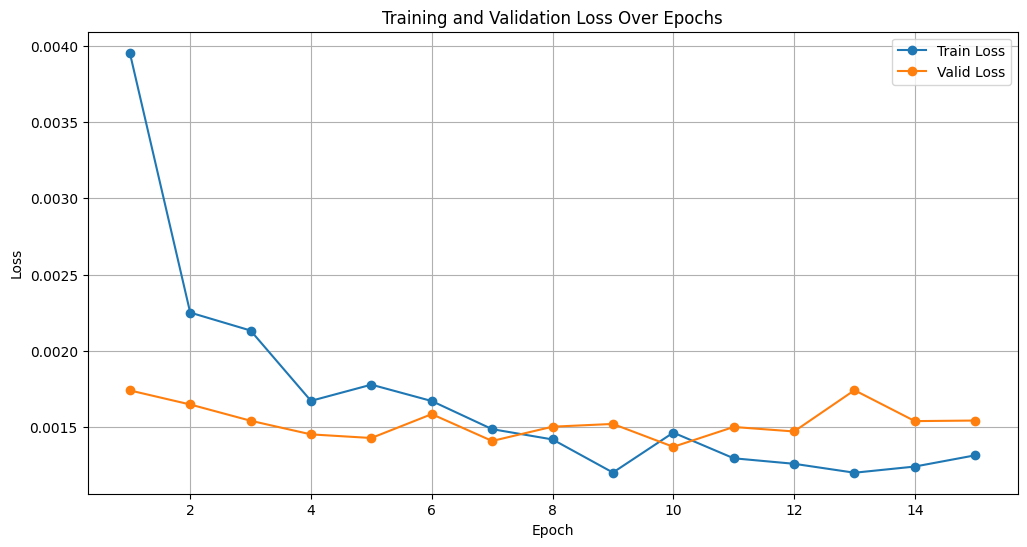

Training Progress: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]

Epoch 15, Train Loss: 0.0013, Valid Loss: 0.0015, LR: 0.000013


In [67]:
train_model_accuracy(model, train_dataset, valid_dataset, optimizer, criterion, num_epochs, device="cuda");

In [70]:
embeddings = extract_embeddings(model, valid_dataset, device="cuda")[0]
for i, (adj, features, index, accuracy) in enumerate(valid_dataset):
    print(f"Index: {index}, Accuracy: {accuracy.item():.3f}, Embedding: {embeddings[i][0]:.3f}")
    if i >= 20:
        break

Index: 303, Accuracy: 0.780, Embedding: 0.792
Index: 121, Accuracy: 0.868, Embedding: 0.849
Index: 569, Accuracy: 0.864, Embedding: 0.831
Index: 591, Accuracy: 0.849, Embedding: 0.825
Index: 24, Accuracy: 0.868, Embedding: 0.820
Index: 192, Accuracy: 0.831, Embedding: 0.856
Index: 77, Accuracy: 0.757, Embedding: 0.813
Index: 524, Accuracy: 0.862, Embedding: 0.821
Index: 302, Accuracy: 0.829, Embedding: 0.807
Index: 6, Accuracy: 0.873, Embedding: 0.836
Index: 233, Accuracy: 0.842, Embedding: 0.844
Index: 39, Accuracy: 0.891, Embedding: 0.860
Index: 141, Accuracy: 0.839, Embedding: 0.819
Index: 153, Accuracy: 0.844, Embedding: 0.835
Index: 448, Accuracy: 0.841, Embedding: 0.851
Index: 316, Accuracy: 0.856, Embedding: 0.818
Index: 384, Accuracy: 0.845, Embedding: 0.773
Index: 611, Accuracy: 0.813, Embedding: 0.828
Index: 357, Accuracy: 0.833, Embedding: 0.823
Index: 369, Accuracy: 0.851, Embedding: 0.868
Index: 351, Accuracy: 0.860, Embedding: 0.858


In [104]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 128  # Размерность скрытого слоя
output_dim = 16
num_epochs = 30

model = GCN(input_dim, output_dim, dropout=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)

Основной код обучения модели похожести.

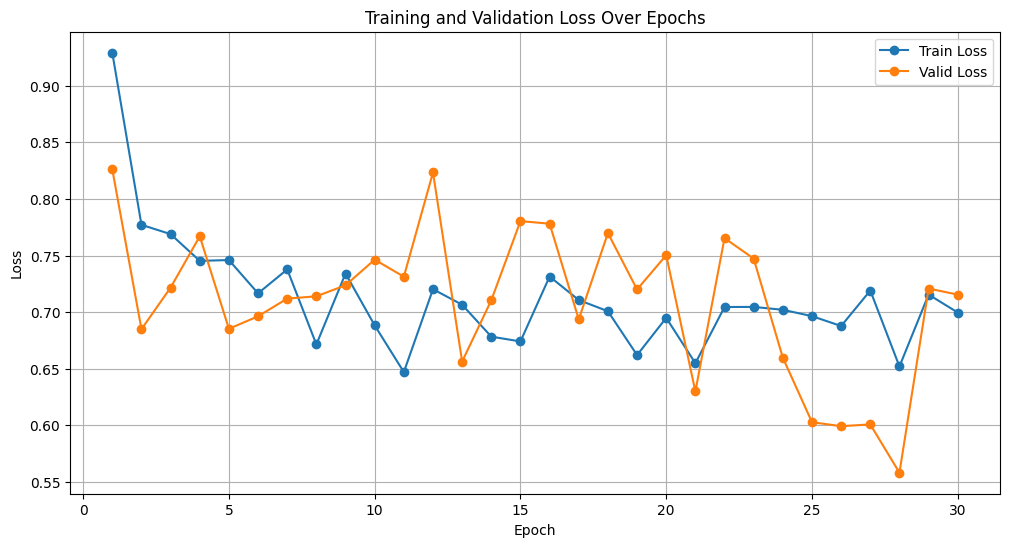

Training Progress: 100%|██████████| 30/30 [04:32<00:00,  9.08s/it]

Epoch 30, Train Loss: 0.6996, Valid Loss: 0.7154, LR: 0.000002


In [105]:
train_model_diversity(model, train_dataset, valid_dataset, optimizer, criterion, num_epochs, device="cuda");

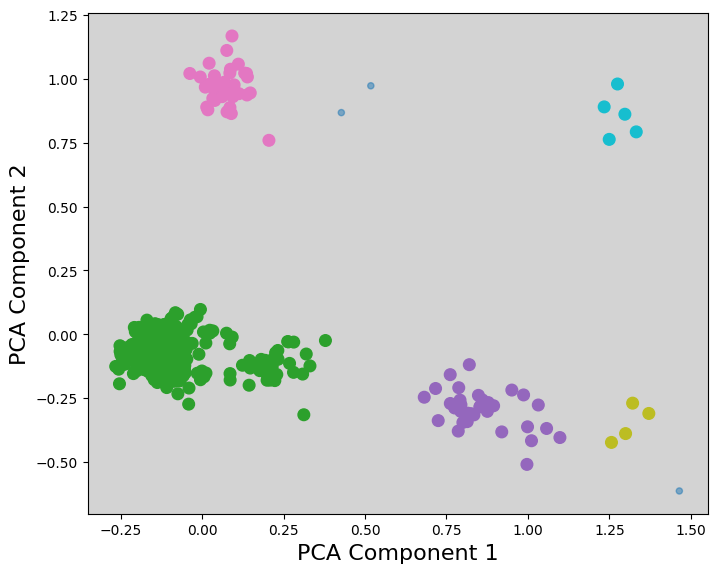

In [106]:
embeddings, indices = extract_embeddings(model, train_dataset, device="cuda")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# optics = OPTICS(min_samples=3, xi=0.025, min_cluster_size=3, metric="euclidean")
# clusters = optics.fit_predict(embeddings)

dbscan = DBSCAN(eps=0.5, min_samples=3, metric="euclidean")
clusters = dbscan.fit_predict(embeddings)

# Строим 2D-график с кластерами
plt.figure(figsize=(8, 6.5))
scatter = plt.scatter(
  embeddings_2d[:, 0], 
  embeddings_2d[:, 1], 
  c=clusters, 
  cmap='tab10',  
  s=np.where(clusters == -1, 20, 70),  
  alpha=np.where(clusters == -1, 0.5, 1)
)
plt.xlabel("PCA Component 1", fontsize=16)
plt.ylabel("PCA Component 2", fontsize=16)

# Создаем легенду для кластеров
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
  if cluster == -1:
    label = "Noise"
  else:
    label = f"Cluster {cluster}"
  plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label, s=50 if cluster != -1 else 20)

# plt.legend(title="Clusters", fontsize=16, title_fontsize=14)
plt.gca().set_facecolor('lightgrey')
plt.show()

In [107]:
embeddings[0]

array([-0.3132187 ,  0.4281764 ,  0.06345338,  0.7402779 ,  0.6037981 ,
        0.6009064 , -0.33160174,  0.98769116,  1.2301681 , -0.3564973 ,
        1.7014936 ,  0.62804806,  0.36767954, -0.32071906,  1.9886693 ,
        1.4712306 ], dtype=float32)

In [108]:
def compute_correlation(models_dict, dataset, model, diversity_matrix, device="cpu"):
    model.to(device)
    model.eval()

    N = len(dataset)
    embeddings = []

    with torch.no_grad():
        for adj, features, index, _ in dataset:
            adj, features = adj.to(device), features.to(device)

            edge_index, _ = dense_to_sparse(adj)

            embedding = model(features, edge_index).cpu().numpy()
            embeddings.append(embedding)

    embeddings = np.array(embeddings)

    distance_matrix = cdist(embeddings, embeddings, metric="euclidean")

    architectures = [models_dict[index] for index in dataset.indices]

    similarity_matrix = np.zeros((N, N))
    for i in tqdm(range(N), desc="Computing similarity matrix"):
        for j in range(i + 1, N):
            arch_i_index = dataset[i][2]
            arch_j_index = dataset[j][2]
            
            similarity_matrix[i, j] = diversity_matrix[arch_i_index, arch_j_index]
            similarity_matrix[j, i] = similarity_matrix[i, j]

    triu_indices = np.triu_indices(N, k=1)

    similarity_values = similarity_matrix[triu_indices]
    embedding_distances = distance_matrix[triu_indices]

    correlation, _ = pearsonr(embedding_distances, similarity_values)

    return correlation

Рассчитаю корреляции

In [109]:
pearson_correlation = compute_correlation(models_dict, valid_dataset, model, diversity_matrix, device="cuda")

print(f"Корреляция Пирсона: {pearson_correlation:.3f}")

Computing similarity matrix: 100%|██████████| 130/130 [00:00<00:00, 2890.68it/s]

Корреляция Пирсона: -0.271


In [115]:
min_samples = 10

for i in tqdm(range(len(set(clusters)) - 1)):
    cluster_indexes = np.where(clusters == i)[0]
    # print(cluster_indexes)
    
    positive_diversity = []
    negative_diversity = []
    
    for index in cluster_indexes:
        if index == cluster_indexes[0]:
            continue
        for _ in range(min_samples):
            positive, negative = get_positive_and_negative(discrete_diversity_matrix, cluster_indexes[0])
            if positive is None or negative is None:
                print(positive, negative)
                continue
            
            positive_diversity.append(get_diversity([index, positive, models_dict[index], models_dict[positive], 2000]))
            negative_diversity.append(get_diversity([index, negative, models_dict[index], models_dict[negative], 2000]))


    mean_positive_diversity = np.mean(positive_diversity) 
    mean_negative_diversity = np.mean(negative_diversity) 

    print(f"Cluster {i}:")
    print(f"  Mean Positive Diversity: {mean_positive_diversity:.4f}" if mean_positive_diversity is not None else "  No positive diversity data available.")
    print(f"  Mean Negative Diversity: {mean_negative_diversity:.4f}" if mean_negative_diversity is not None else "  No negative diversity data available.")


 20%|██        | 1/5 [00:12<00:49, 12.36s/it]

Cluster 0:
  Mean Positive Diversity: 200.2744
  Mean Negative Diversity: 191.9298


 40%|████      | 2/5 [00:13<00:16,  5.65s/it]

Cluster 1:
  Mean Positive Diversity: 184.4056
  Mean Negative Diversity: 193.3639


 60%|██████    | 3/5 [00:14<00:07,  3.53s/it]

Cluster 2:
  Mean Positive Diversity: 191.2401
  Mean Negative Diversity: 194.4383
Cluster 3:
  Mean Positive Diversity: 255.6590
  Mean Negative Diversity: 254.4480


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

Cluster 4:
  Mean Positive Diversity: 241.6746
  Mean Negative Diversity: 239.5642


In [118]:
cluster_1_indexes = np.where(clusters == 1)[0]
cluster_2_indexes = np.where(clusters == 2)[0]

similarities_within_cluster_1 = [
    get_diversity([i, j, models_dict[i], models_dict[j], 2000])
    for i in cluster_1_indexes
    for j in cluster_1_indexes
    if i != j
]
mean_similarity_within_cluster_1 = np.mean(similarities_within_cluster_1)

similarities_between_clusters = [
    get_diversity([i, j, models_dict[i], models_dict[j], 2000])
    for i in cluster_1_indexes
    for j in cluster_2_indexes
]
mean_similarity_between_clusters = np.mean(similarities_between_clusters)

print(f"Средняя похожесть внутри первого кластера: {mean_similarity_within_cluster_1:.4f}")
print(f"Средняя похожесть между первым и вторым кластерами: {mean_similarity_between_clusters:.4f}")

Средняя похожесть внутри первого кластера: 159.2345
Средняя похожесть между первым и вторым кластерами: 166.2215


In [ ]:
with open("logs.txt", "w", encoding="utf-8") as log:
    for index in cluster_1_indexes:
        tmp_graph = Graph(models_dict[index], index=index)
        for key, value in models_dict[index]["architecture"].items():
            log.write(f"{key}: {value}\n")
        log.write("\n")  # Добавляем пустую строку между архитектурами